# Imports

In [1]:
%%bash
wget https://raw.githubusercontent.com/peto184/37/master/test.csv
wget https://raw.githubusercontent.com/peto184/37/master/train.csv

--2018-05-03 08:32:57--  https://raw.githubusercontent.com/peto184/37/master/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350924 (343K) [text/plain]
Saving to: ‘test.csv’

     0K .......... .......... .......... .......... .......... 14% 3.08M 0s
    50K .......... .......... .......... .......... .......... 29% 10.2M 0s
   100K .......... .......... .......... .......... .......... 43% 19.8M 0s
   150K .......... .......... .......... .......... .......... 58% 29.8M 0s
   200K .......... .......... .......... .......... .......... 72% 14.1M 0s
   250K .......... .......... .......... .......... .......... 87% 21.4M 0s
   300K .......... .......... .......... .......... ..        100% 54.9M=0.03s

2018-05-03 08:32:57 (10.7 MB/s) - ‘test.csv’ saved [3

In [1]:
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from pandas.io.json import json_normalize
import json
from sklearn.cross_validation import cross_val_score

from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np
from dateutil.parser import parse as dtparse

# To display all columns when printing
pd.set_option('display.max_columns', None)

C:\Users\peter\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Classes

In [40]:
#parses data from JSON
class JSONTransformer(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, data, **transform_params):
        jsons = pd.DataFrame(data[self.column])
        jsons[self.column] = jsons[self.column].apply(lambda x : x.replace('\'', '\"'))
        jsons = jsons[self.column].apply(json.loads).values.tolist() 
        medical_info = pd.DataFrame(jsons)
        
        data = pd.concat([data, pd.DataFrame(medical_info)], axis=1)
        data = data.drop(columns=[self.column])
        
        return data
      
class NumericTransformer(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        df[self.column] = pd.to_numeric(df[self.column], errors='coerce')
        return df  
#replaces all occurrences of a given value with target value
class InconsistencyTransformer(TransformerMixin):
    def __init__(self, column, source, target):
        self.column = column
        self.source = source
        self.target = target
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        sample = df[self.column] == self.source
        df.loc[sample, self.column] = self.target
        return df

#applies an operation to a specific column of dataframe
class ColumnFixer(TransformerMixin):
    def __init__(self, column, operation):
        self.column = column
        self.operation = operation
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, data, **transform_params):
        data[self.column] = data[self.column].apply(self.operation)
        return data
      
#unifies all date formats
class DateUnifier(BaseEstimator, TransformerMixin):
    def parseDate(self, s):
        if pd.isnull(s):
            return s
          
        parsed = dtparse(s.split(" ")[0])
        currentYear = 2018
        if currentYear-parsed.year < 0:
            parsed = dtparse("{0}-{1}-{2}".format(parsed.year-100, parsed.month, parsed.day))
            
        return parsed.date()
  
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None):
        return self 
            
    def transform(self, data):
        data[self.column] = data[self.column].apply(self.parseDate)
        return data
      
#fills in the missing values to a specific column using chosen filling strategy
class MissingValuesImputer(BaseEstimator, TransformerMixin):
    def __init__(self, column, strategy='mean',filler=None):
        self.column = column
        self.strategy = strategy
        self.fill = filler

    def fit(self, data, y=None):
        if self.strategy == 'mean':
            self.fill = data[self.column].mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'remove':
            None
        
        # Fill here more strategies if needed
            
        return self

    def transform(self, data, y=None):
        if self.strategy == 'remove':
            data.dropna(subset=[self.column],inplace=True)
        else :
            data[self.column].fillna(self.fill, inplace=True)
        return data
      
import math

#fills in the missing values using linear reggresion
class MissingValuesLinearRegressionImputer(BaseEstimator, TransformerMixin):
    def fun(self, row):
        if not (math.isnan(row[self.src])) and (math.isnan(row[self.tar])):
            pred_tar = self.lr.predict(row[self.src])[0]
        else:
            pred_tar = row[self.tar]

        return pred_tar
    
    
    def __init__(self, src, tar):
        self.tar = tar
        self.src = src

    def fit(self, data, y=None):       
        sample = data[[self.src, self.tar]].dropna()
        
        self.lr = LinearRegression()
        self.lr.fit(sample[self.src].values.reshape(-1,1), sample[self.tar])
        return self

    def transform(self, data, y=None):
        data[self.tar] = data.apply(lambda row: self.fun(row), axis=1)
        return data
      
#fixes all outlier values in a specific column by setting them to a upper or lower boundary value 
class FixOutliersByQuantile(TransformerMixin):
    def __init__(self, column, upper_quantile=.95, lower_quantile=.05):
        self.column = column
        self.upper_quantile = upper_quantile
        self.lower_quantile = lower_quantile
        None
        
    def fit(self, data, y=None, **fit_params):
        self.upper_boundary = data[self.column].quantile(self.upper_quantile)
        self.lower_boundary = data[self.column].quantile(self.lower_quantile)
        return self
    
    def transform(self, data, **transform_params):
        data.loc[data[self.column] > self.upper_boundary, self.column] = self.upper_boundary
        data.loc[data[self.column] < self.lower_boundary, self.column] = self.lower_boundary
        return data   

#normalizes values in a specific column by scaling the data to an interval (-1,1)
class NormalizeStandartScaler(TransformerMixin):
    def __init__(self, column):
        self.column = column
        None
        
    def fit(self, data, y=None, **fit_params):
        self.scaler = StandardScaler()
        self.scaler.fit(data[self.column].values.reshape(-1,1))
        
        return self
    
    def transform(self, data, **transform_params):
        data[self.column] = self.scaler.transform(data[self.column].values.reshape(-1, 1))
        return data     
      
class BoolTransform(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        None
        
    def fit(self, data, y=None, **fit_params):
        return self
    
    def transform(self, data, **transform_params):   
        for c in self.columns:
            sample = data[c] == 'f'
            data.loc[sample, c] = '0'
            sample = data[c] == 't'
            data.loc[sample, c] = '1'
            
        return data
        
#performs a various transformations on data (dropping undesired columns, filing missing sex values using another attribute, ...)
class VariousTransformer(TransformerMixin):  
    def __init__(self, ):
        None
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        
        # Remove the 'capital-gain' and 'capital-loss' and combine them into categorical column 
        df.loc[df['capital-gain'] > 0.0, 'capital'] = 'Positive'
        df.loc[df['capital-loss'] > 0.0, 'capital'] = 'Negative'
        df['capital'].fillna('None', inplace=True)
        df.drop(columns=['capital-gain', 'capital-loss'], inplace=True)
        
        # Drop 'TBG' and 'TBG measured', because they give no information
        # 'TBG measured' is all false
        # 'TBG' is all missing
        df.drop(columns=['TBG measured', 'TBG'], inplace=True)
        
        # Drop 'date_of_birth', because it is exactly same information as 'age'
        # df.drop(columns=['date_of_birth'], inplace=True)
        
        # Drop 'referral source'
        # df.drop(columns=['referral source'], inplace=True)
        
        # Drop 'education', because 'education-num' is the same information
        df.drop(columns=['education'], inplace=True)
        
        # Drop 'X' measured, because it provides no information
        df.drop(columns=['T3 measured', 'TT4 measured', 'FTI measured', 'T4U measured', 'TSH measured'], inplace=True)
        df.loc[(df["sex"] == '?') & (df["relationship"] == 'Husband'), "sex"] = 'M' 
        df.loc[(df["sex"] == '?') & (df["relationship"] == 'Wife'), "sex"] = 'F' 
        df.loc[(df["sex"] == '?') & (df["pregnant"] == 't'), "sex"] = 'F' 
        
       
        return df
      
      

# Classifiers

In [41]:
class CustomClassifier(ClassifierMixin):  
    def __init__(self):
        None
        
    def fit(self, X, y_true=None):
        
        # Decreased binding protein boundaries
        self.dec_t4u_lower = X["T4U"].quantile(0.01)
        self.dec_tt4_lower = X["TT4"].quantile(0.25)
        self.dec_t3_lower = X["T3"].quantile(0.04)
        
        # Increased binding protein boundaries
        self.inc_t3u_higher = X["T3"].quantile(0.905)
        self.inc_fti_higher = X["FTI"].quantile(0.07)
        self.inc_fti_lower = X["FTI"].quantile(0.78)
        self.inc_tt4_higher = X["TT4"].quantile(0.60)
        self.inc_tsh_lower = X["TSH"].quantile(0.60)
        self.inc_age_lower = X["age"].quantile(0.3)
        self.inc_t4u_higher = X["T4U"].quantile(0.96)
        
        return self
      
    def predict(self, X):
        # Create classifier
        y_pred = pd.DataFrame(np.zeros((len(X), 1)), columns=['class'])        
        y_pred['class'] = 'negative'
        
        y_pred['class'][X.loc[(
            (X['T4U'] < self.dec_t4u_lower) 
            & (X['TT4'] < self.dec_tt4_lower) 
            & (X['T3'] < self.dec_t3_lower)
            & (X['TSH'] < self.inc_tsh_lower)
            & (X['lithium'] != "t")
            & (X['hypopituitary'] != "t")
            
        )].index] = 'decreased binding protein'
        
        y_pred['class'][X.loc[(
            (X['T3'] > self.inc_t3u_higher) 
            #& (X['FTI'] > self.inc_fti_higher) 
            #& (X['FTI'] < self.inc_fti_lower)
            & (X['TT4'] > self.inc_tt4_higher) 
            #& (X['TSH'] < self.inc_tsh_lower)
            #& (X['age'] < 40)
            #& (X['age'] > 20)
            & (X['T4U'] > self.inc_t4u_higher)
            & (X['lithium'] != "t")
            & (X['hypopituitary'] != "t")
            #& (X['fnlwgt'] > X["fnlwgt"].quantile(0.4))
        )].index] = 'increased binding protein'
                       
        return y_pred
    
    
    def score(self, X, y_true):
       
        y_pred = self.predict(X)
      
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
      
        return accuracy, precision, recall

In [42]:

class DumbClassifier(BaseEstimator, ClassifierMixin):  
    def __init__(self):
        None
        
    def fit(self, X, y_true=None):
        # Train itself here        
        return self

    def predict(self, X, y_true=None):
        # Predict everyone to be negative, first 10 to be increased binding protein, and last 10 to be decreased binding protein
        y_pred = pd.DataFrame(np.zeros((len(X), 1)), columns=['class'])
        y_pred['class'] = 'negative'
        y_pred['class'][:10] = 'increased binding protein'
        y_pred['class'][-10:] = 'decreased binding protein'
        return y_pred
      
    def score(self, X, y_true):
        y_pred = self.predict(X)
      
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
      
        return accuracy, precision, recall      

# Main - preprocessing

In [55]:
# Load raw csv file
train = pd.read_csv('train.csv', sep=',', index_col=0)
test = pd.read_csv('test.csv', sep=',', index_col=0)

In [56]:
bool_columns = ['query on thyroxine', 'on antithyroid medication', 'thyroid surgery','I131 treatment','tumor','hypopituitary',
     'goitre', 'lithium', 'on thyroxine', 'pregnant','psych','query hyperthyroid', 'query hypothyroid', 'sick']
    

In [57]:
ppl = Pipeline([
            ('transform JSON', JSONTransformer('medical_info')),
    
            ('transform FALSE to f', InconsistencyTransformer('on thyroxine', 'FALSE', 'f')),
            ('transform TRUE to t', InconsistencyTransformer('on thyroxine', 'TRUE', 't')),
            ('transform F to f', InconsistencyTransformer('on thyroxine', 'F', 'f')),
            ('transform T to t', InconsistencyTransformer('on thyroxine', 'T', 't')),
    
            ('transform ?? to NaN', InconsistencyTransformer('query hypothyroid', '??', '?')),
            ('transform nan to ?', InconsistencyTransformer('query hypothyroid', 'nan', '?')),

    
            ('FTI to numeric', NumericTransformer('FTI')),
            ('TBG to numeric', NumericTransformer('TBG')),
    
            #('transform workclass " ?" to "?"', InconsistencyTransformer('workclass', ' ?', '?')),
            #('transform occupation " ?" to "?"', InconsistencyTransformer('occupation', ' ?', '?')),
            #('transform native-country " ?" to "?"', InconsistencyTransformer('native-country', ' ?', '?')),
    
            ('fix the .|num in class', ColumnFixer('class', lambda x : x.split('.')[0])),
            ('transform - to _ in relationship', ColumnFixer('relationship', lambda x : x.replace('-','_'))),
            ('lower case the referral source', ColumnFixer('referral source', lambda x : x.lower())),
    
            # Strip leading whitespaces from columns
            ('strip whitespace from workclass', ColumnFixer('workclass', lambda x : x.replace(' ',''))),
            ('strip whitespace from marital-status', ColumnFixer('marital-status', lambda x : x.replace(' ',''))),
            ('strip whitespace from occupation', ColumnFixer('occupation', lambda x : x.replace(' ',''))),
            ('strip whitespace from race', ColumnFixer('race', lambda x : x.replace(' ',''))),
            ('strip whitespace from native-country', ColumnFixer('native-country', lambda x : x.replace(' ',''))),
            ('strip whitespace from relationship', ColumnFixer('relationship', lambda x : x.replace(' ',''))),
    
            # Fill some of the missing values using linear regression, the coeff between them was ~0.5
            ('linear correlation TT4->T4U', MissingValuesLinearRegressionImputer('TT4', 'T4U')),
            ('linear correlation TT4->T3', MissingValuesLinearRegressionImputer('TT4', 'T3')),
            ('linear correlation TT4->FTI', MissingValuesLinearRegressionImputer('TT4', 'FTI')),
    
            # Fill rest of the missing values with mean
            ('tsh by mean values', MissingValuesImputer('TSH', strategy='mean', filler='NaN')),
            ('T3 by mean values', MissingValuesImputer('T3', strategy='mean', filler='NaN')),
            ('tt4 by mean values', MissingValuesImputer('TT4', strategy='mean', filler='NaN')),
            ('T4U by mean values', MissingValuesImputer('T4U', strategy='mean', filler='NaN')),
            ('fti by mean values', MissingValuesImputer('FTI', strategy='mean', filler='NaN')),
            ('age remove missing', MissingValuesImputer('age', strategy='remove', filler='NaN')),
             
    
            ('standartscale TT4', NormalizeStandartScaler('TT4')),
            ('standartscale FTI', NormalizeStandartScaler('FTI')),
            ('standartscale T3', NormalizeStandartScaler('T3')),
            ('standartscale TSH', NormalizeStandartScaler('TSH')),
            ('standartscale T4U', NormalizeStandartScaler('T4U')),
    
             # Fixing outliers
            ('clip TSH', FixOutliersByQuantile('TSH', upper_quantile=.975, lower_quantile=.025)), 
            ('clip TT4', FixOutliersByQuantile('TT4', upper_quantile=.999, lower_quantile=.001)), 
            ('clip T3', FixOutliersByQuantile('T3', upper_quantile=.999, lower_quantile=.001)), 
            ('clip FTI', FixOutliersByQuantile('FTI', upper_quantile=.999, lower_quantile=.001)), 
            ('clip age', FixOutliersByQuantile('age', upper_quantile=.999, lower_quantile=.001)), 
    
            # Other transformations which did not fit in a separate class
            ('Various transforms', VariousTransformer()),
      
            # Replace the rest of missing values of categorical attributes with Unknown value
            ('transform race values ? to Unknown', InconsistencyTransformer('race', '?', 'Other')),
            ('transform sex value ? to Unknown', InconsistencyTransformer('sex', '?', 'Unknown')),
            ('transform workclass values ? to Unknown', InconsistencyTransformer('workclass', '?', 'Unknown')),
            ('transform occupation values ? to Unknown', InconsistencyTransformer('occupation', '?', 'Unknown')),
            ('transform relationship values ? to Unknown', InconsistencyTransformer('relationship', '?', 'Unknown')),
            ('transform native-country values ? to Unknown', InconsistencyTransformer('native-country', '?', 'Unknown')),
            ('transform query hypotheroid values ? to Unknown', InconsistencyTransformer('query hypothyroid', '?', 'Unknown')),
     
            ('unify date formats', DateUnifier('date_of_birth')),
            ('transform bool values', BoolTransform(bool_columns))
    
      ])

In [58]:
# Preprocessing
model = ppl.fit(train)

train_t = model.transform(train)
test_t = model.transform(test)

In [59]:
train_t.to_csv('preprocessed_data/normalized_train_data.csv', sep=',');
test_t.to_csv('preprocessed_data/normalized_test_data.csv', sep=',');

In [51]:
train_t.head()

,age,sex,query on thyroxine,on antithyroid medication,thyroid surgery,I131 treatment,tumor,hypopituitary,TSH,T3,TT4,T4U,FTI,referral source,class,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,hours-per-week,native-country,date_of_birth,goitre,lithium,on thyroxine,pregnant,psych,query hyperthyroid,query hypothyroid,sick,capital
0,62.0,M,0,0,0,0,0,0,1.30,1.500000,96.0,0.88,109.0,svhc,negative,Federal-gov,35576,10,Married-civ-spouse,Craft-repair,Husband,White,40,United-States,1956-02-17,0,0,0,0,0,0,0,0,None
1,47.0,F,0,0,0,0,0,0,2.00,2.097762,114.0,0.89,129.0,other,negative,Private,315291,9,Never-married,Adm-clerical,Unmarried,Black,40,United-States,1970-12-15,0,0,0,0,0,0,0,0,None
2,64.0,F,0,0,0,0,0,0,0.68,1.400000,92.0,0.81,114.0,svi,negative,Private,134004,10,Married-civ-spouse,Exec-managerial,Wife,White,40,United-States,1953-10-05,0,0,0,0,0,0,1,0,None
3,20.0,F,0,0,0,0,0,0,1.30,1.700000,104.0,0.96,108.0,other,negative,Private,161674,9,Never-married,Machine-op-inspct,Unmarried,White,40,United-States,1998-01-31,0,0,0,0,0,0,0,0,None
4,21.0,F,0,0,0,0,0,0,0.40,3.400000,189.0,1.35,140.0,other,increased binding protein,Private,187264,9,Married-civ-spouse,Exec-managerial,Wife,White,55,United-States,1996-10-09,0,0,0,0,0,1,0,0,None


In [8]:
# Classification
classifier = CustomClassifier()
classifier.fit(train_t)

y_pred = classifier.predict(test_t)
y_true = test_t['class']

acc, pre, rec = classifier.score(test_t, test_t['class'])
print('Accuracy: %f, Precision: %f, Recall: %f' % (acc, pre, rec))
confusion_matrix(y_true, y_pred, labels=['negative', 'increased binding protein', 'decreased binding protein'])
#Accuracy: 0.955761, Precision: 0.611176, Recall: 0.790092


Accuracy: 0.976337, Precision: 0.784755, Recall: 0.703482


array([[933,   8,   1],
       [ 12,  13,   0],
       [  2,   0,   3]], dtype=int64)

# Dataset after preprocessing
Nizsie je len cast prieskumnej analyzi aby sa zistilo ako sa zmenili hodnoty po pred spracovani. Na konci sa nachadza zaverecna sprava.

In [10]:
train_t.head()

,age,sex,query on thyroxine,on antithyroid medication,thyroid surgery,I131 treatment,tumor,hypopituitary,TSH,T3,TT4,T4U,FTI,referral source,class,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,hours-per-week,native-country,date_of_birth,goitre,lithium,on thyroxine,pregnant,psych,query hyperthyroid,query hypothyroid,sick,capital
0,62.0,M,f,f,f,f,f,f,-0.165926,-0.706864,-0.382022,-0.634582,-0.047839,svhc,negative,Federal-gov,35576,10,Married-civ-spouse,Craft-repair,Husband,White,40,United-States,1956-02-17,f,f,f,f,f,f,f,f,None
1,47.0,F,f,f,f,f,f,f,-0.131497,0.084090,0.144159,-0.580364,0.587692,other,negative,Private,315291,9,Never-married,Adm-clerical,Unmarried,Black,40,United-States,1970-12-15,f,f,f,f,f,f,f,f,None
2,64.0,F,f,f,f,f,f,f,-0.196419,-0.839183,-0.498951,-1.014104,0.111044,svi,negative,Private,134004,10,Married-civ-spouse,Exec-managerial,Wife,White,40,United-States,1953-10-05,f,f,f,f,f,f,t,f,None
3,20.0,F,f,f,f,f,f,f,-0.165926,-0.442225,-0.148164,-0.200842,-0.079615,other,negative,Private,161674,9,Never-married,Machine-op-inspct,Unmarried,White,40,United-States,1998-01-31,f,f,f,f,f,f,f,f,None
4,21.0,F,f,f,f,f,f,f,-0.210191,1.807203,2.336582,1.913638,0.937234,other,increased binding protein,Private,187264,9,Married-civ-spouse,Exec-managerial,Wife,White,55,United-States,1996-10-09,f,f,f,f,f,t,f,f,None


In [11]:
train_t.describe()

,age,TSH,T3,TT4,T4U,FTI,fnlwgt,education-num,hours-per-week
count,2799.000000,2799.000000,2799.000000,2799.000000,2.799000e+03,2799.000000,2.799000e+03,2799.000000,2799.000000
mean,51.714400,-0.077815,-0.001815,-0.002921,6.809685e-16,-0.000993,1.901326e+05,10.096106,38.567703
std,19.003061,0.240425,0.983593,0.977858,1.000179e+00,0.990617,1.063648e+05,2.401687,11.869328
min,1.000000,-0.229126,-2.559334,-3.024681,-3.724976e+00,-3.299315,1.228500e+04,1.000000,1.000000
25%,36.000000,-0.200600,-0.544352,-0.586648,-5.803641e-01,-0.524487,1.191815e+05,9.000000,35.000000
50%,54.000000,-0.151171,-0.045267,-0.060467,-3.818969e-02,-0.047839,1.782720e+05,10.000000,40.000000
75%,67.000000,-0.047885,0.351691,0.407250,3.955499e-01,0.365256,2.344010e+05,12.000000,40.000000
max,93.202000,1.070055,6.597426,5.330671,6.088381e+00,7.661973,1.366120e+06,16.000000,99.000000


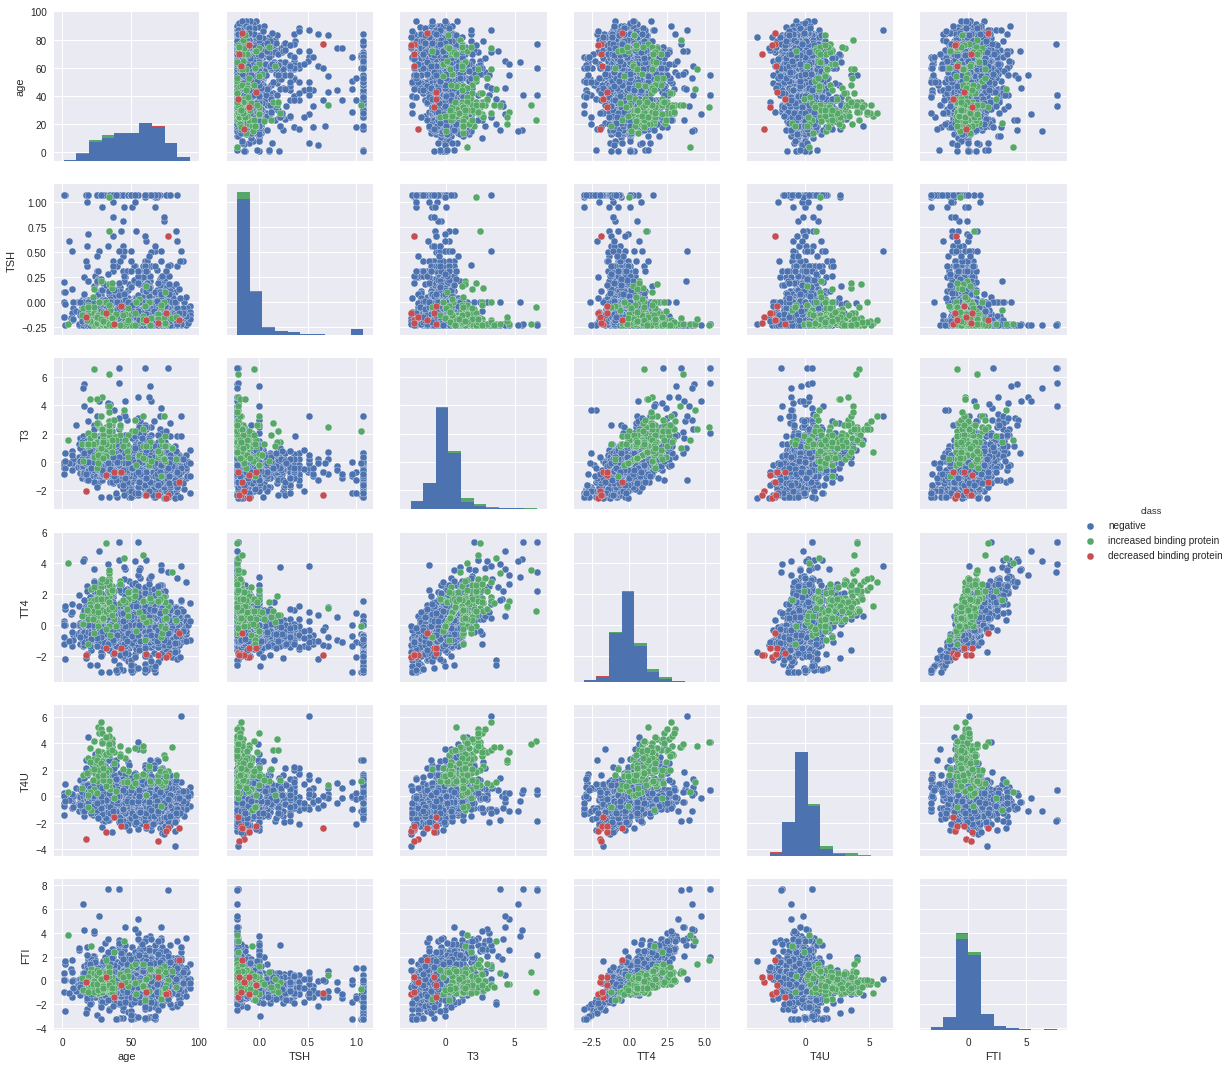

In [12]:
sb.pairplot(train_t[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'] + ['class']], hue = 'class')

#Age

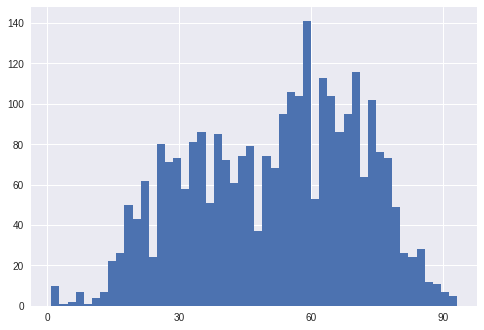

In [13]:
age = train_t["age"]
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))

# histogram
age.hist(bins = 50)


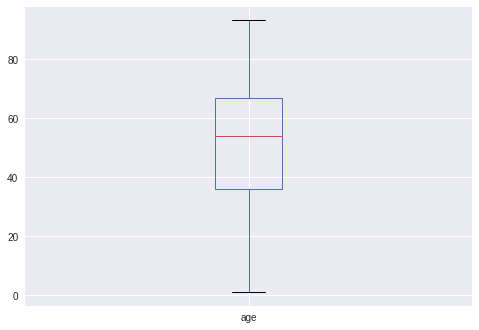

In [14]:
age.plot(kind='box')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


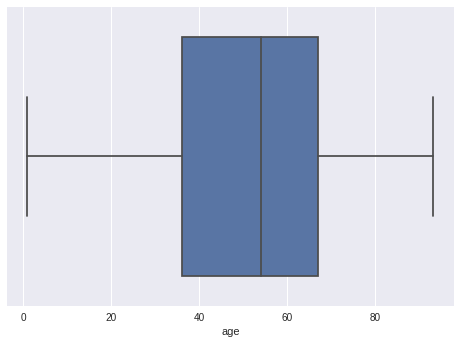

In [15]:
sb.boxplot(age, sym='k.')

#Sex, relationship, workclass, occupation, native-country, race, marital-status

F          1837
M           912
Unknown      50
Name: sex, dtype: int64


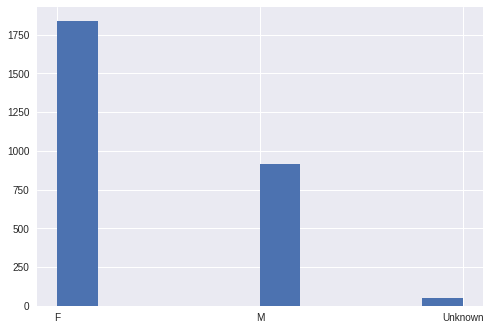

In [16]:
sex = train_t["sex"]
print(sex.value_counts())
sex.hist()

Not_in_family     874
Husband           559
Own_child         504
Unmarried         490
Wife              273
Other_relative     99
Name: relationship, dtype: int64


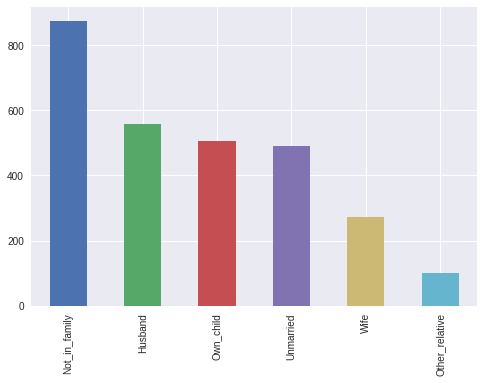

In [17]:
relationship = train_t["relationship"]
print(relationship.value_counts())
relationship.value_counts().plot(kind='bar')

Private             2002
Unknown              214
Local-gov            207
Self-emp-not-inc     152
State-gov             97
Federal-gov           76
Self-emp-inc          49
Never-worked           1
Without-pay            1
Name: workclass, dtype: int64


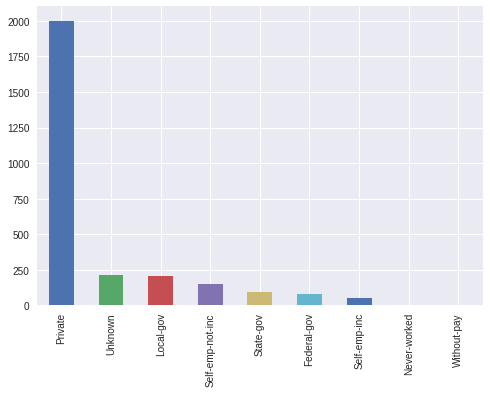

In [18]:
workclass = train_t["workclass"]
print(workclass.value_counts())
workclass.value_counts().plot(kind='bar')

Adm-clerical         495
Other-service        425
Prof-specialty       375
Sales                304
Exec-managerial      291
Unknown              215
Craft-repair         192
Machine-op-inspct    158
Handlers-cleaners     88
Tech-support          77
Transport-moving      70
Farming-fishing       51
Protective-serv       37
Priv-house-serv       21
Name: occupation, dtype: int64


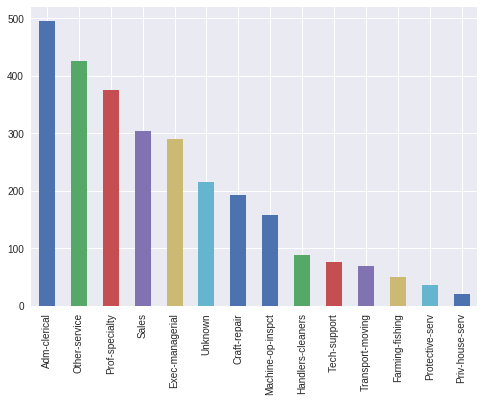

In [19]:
occupation = train_t["occupation"]
print(occupation.value_counts())
occupation.value_counts().plot(kind='bar')

United-States                 2511
Unknown                         53
Mexico                          44
Philippines                     18
Jamaica                         12
El-Salvador                     11
Cuba                            11
Germany                         11
Canada                          10
Vietnam                          9
Poland                           8
Puerto-Rico                      8
England                          8
China                            8
Guatemala                        7
India                            6
South                            6
Japan                            6
France                           5
Taiwan                           5
Columbia                         5
Portugal                         4
Ireland                          3
Dominican-Republic               3
Haiti                            3
Peru                             3
Italy                            2
Scotland                         2
Cambodia            

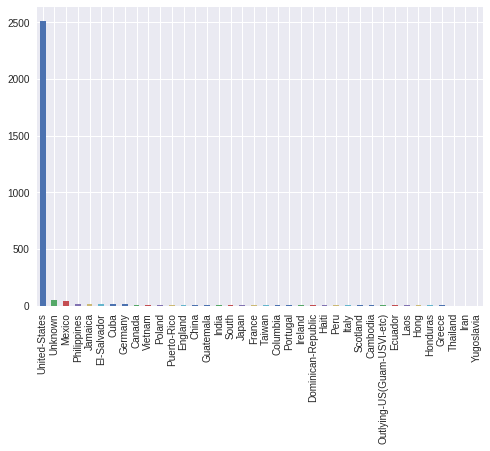

In [20]:

native_country = train_t["native-country"]
print(native_country.value_counts())
native_country.value_counts().plot(kind='bar')


White                 2328
Black                  303
Asian-Pac-Islander     109
Amer-Indian-Eskimo      30
Other                   29
Name: race, dtype: int64


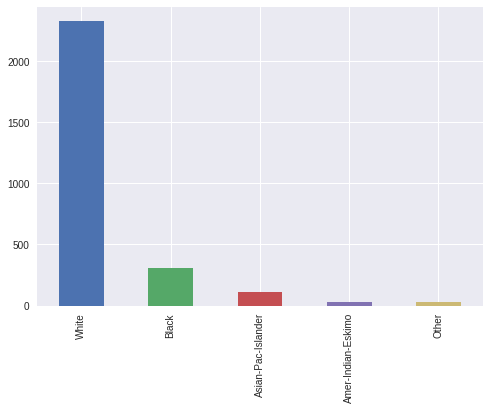

In [21]:
race = train_t["race"]
print(race.value_counts())
race.value_counts().plot(kind='bar')

In [0]:
education = train_t["education-num"]
print(education.value_counts())
education.value_counts().plot(kind='bar')

Never-married            1132
Married-civ-spouse        857
Divorced                  521
Widowed                   140
Separated                 110
Married-spouse-absent      38
Married-AF-spouse           1
Name: marital-status, dtype: int64


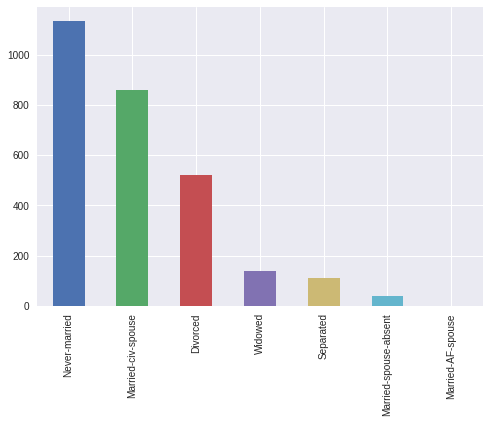

In [23]:
marital_status = train_t["marital-status"]
print(marital_status.value_counts())
marital_status.value_counts().plot(kind='bar')

#Markers

In [24]:
marker_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'fnlwgt']
train_t[marker_columns]

,TSH,T3,TT4,T4U,FTI,fnlwgt
0,-0.165926,-0.706864,-0.382022,-0.634582,-0.047839,35576
1,-0.131497,0.084090,0.144159,-0.580364,0.587692,315291
2,-0.196419,-0.839183,-0.498951,-1.014104,0.111044,134004
3,-0.165926,-0.442225,-0.148164,-0.200842,-0.079615,161674
4,-0.210191,1.807203,2.336582,1.913638,0.937234,187264
5,-0.165926,0.484010,-0.791274,-0.471929,-0.651593,222249
6,-0.170844,-0.706864,0.144159,-0.038190,0.142820,150042
7,-0.072477,-0.442225,0.494947,1.317246,-0.302051,80710
8,-0.087232,0.219371,1.079593,2.618465,-0.397381,240612
9,-0.170844,-0.045267,-0.586648,-0.259068,-0.469295,61751


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


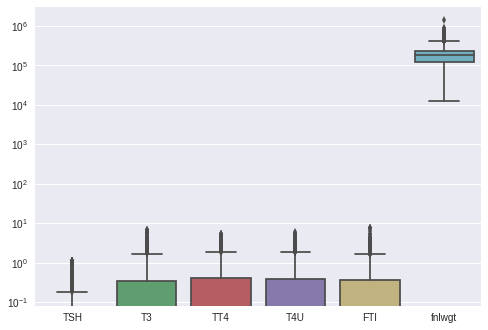

In [25]:
g = sb.boxplot(train_t[marker_columns])
g.set_yscale('log')

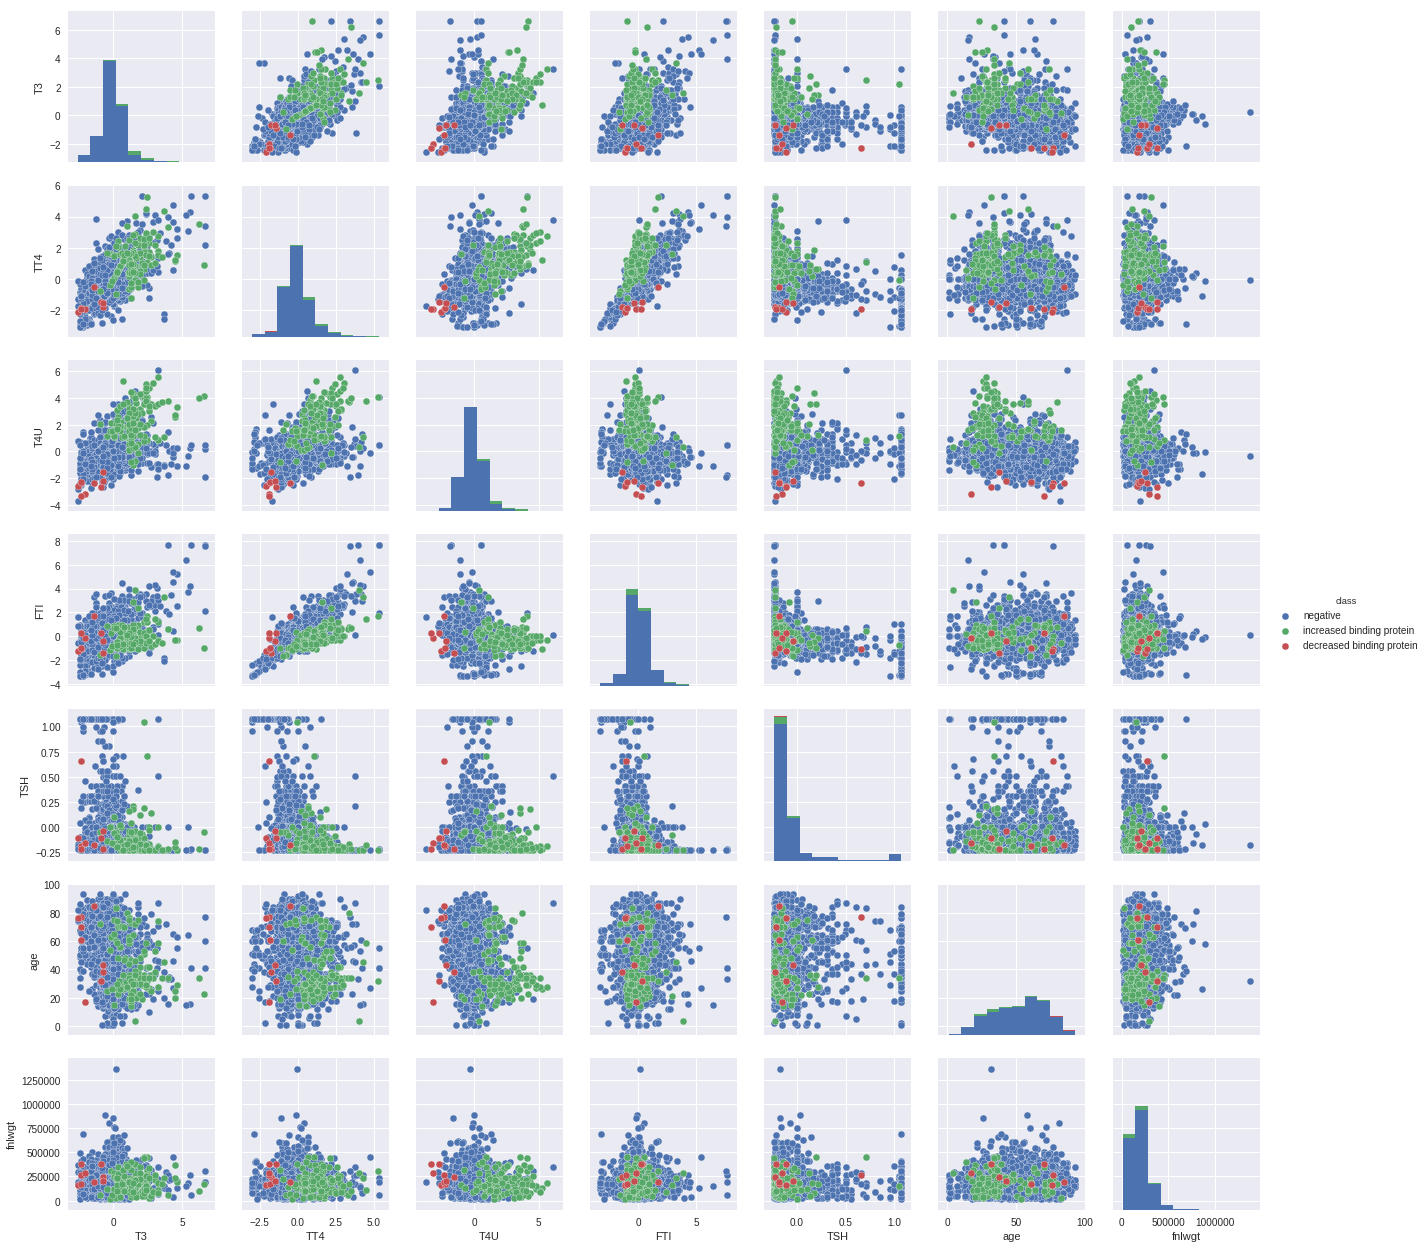

In [26]:
numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
marker_cols = ['T3', 'TT4', 'T4U', 'FTI', 'TSH', "age", "fnlwgt"]
sb.pairplot(train_t[marker_cols + ['class']], hue = 'class')

# Correlation between class attribute and other attributes

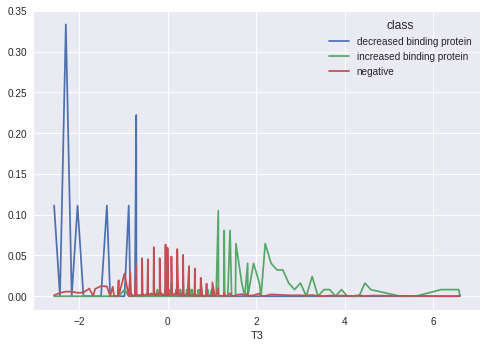

In [27]:
pd.crosstab(index=train_t["class"],  columns=[train_t["T3"]], normalize = "index").transpose().plot()

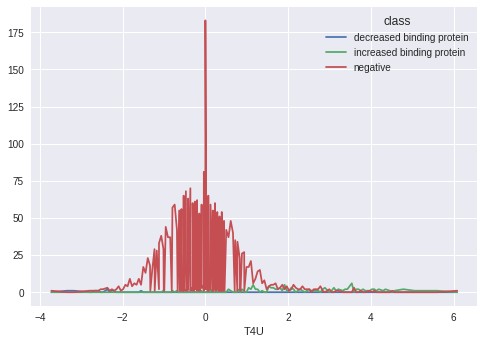

In [28]:
pd.crosstab(index=train_t["class"],  columns=[train_t["T4U"]]).transpose().plot()

In [29]:
train_t["TSH"].quantile(0.60)

-0.12657888336736559

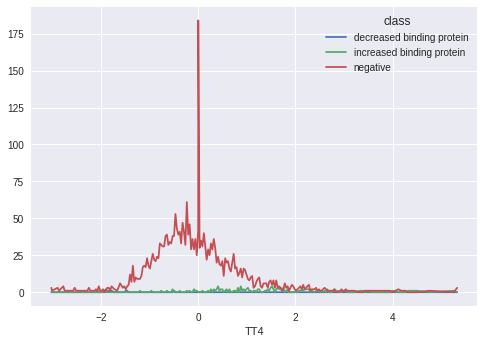

In [30]:
pd.crosstab(index=train_t["class"],  columns=[train_t["TT4"]]).transpose().plot()

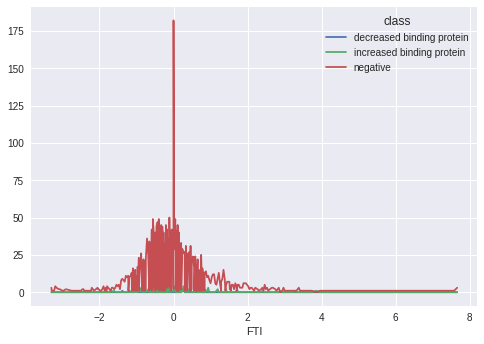

In [31]:
pd.crosstab(index=train_t["class"],  columns=[train_t["FTI"]]).transpose().plot()

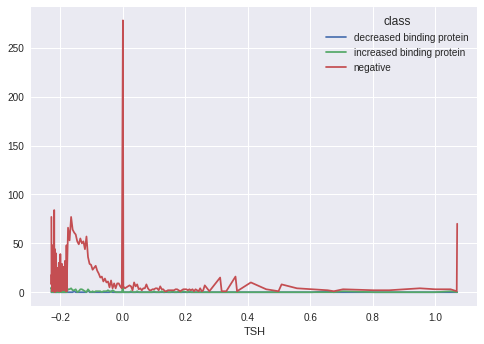

In [32]:
pd.crosstab(index=train_t["class"],  columns=[train_t["TSH"]]).transpose().plot()

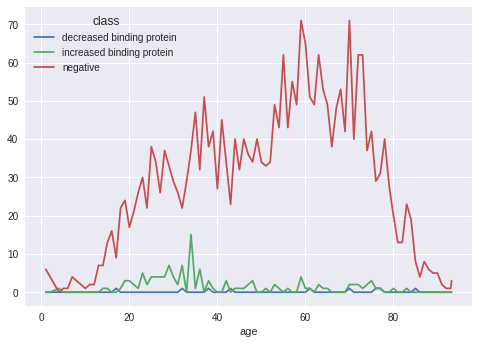

In [33]:
pd.crosstab(index=train_t["class"],  columns=[train_t["age"]]).transpose().plot()

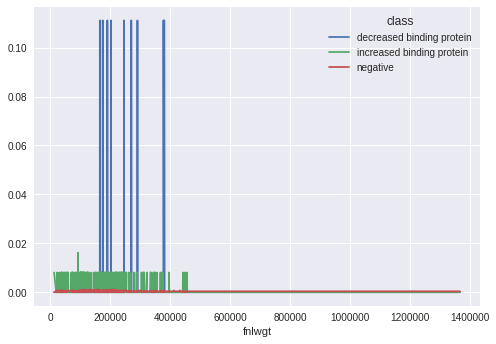

In [34]:
pd.crosstab(index=train_t["class"],  columns=[train_t["fnlwgt"]], normalize = "index").transpose().plot()

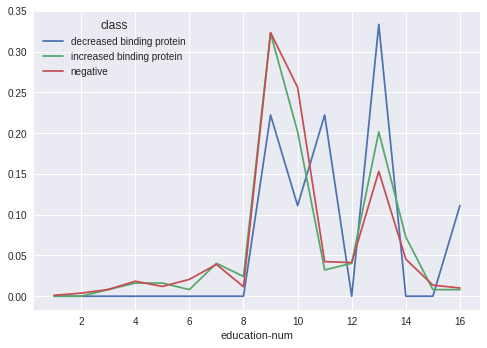

In [35]:
pd.crosstab(index=train_t["class"],  columns=[train_t["education-num"]], normalize = "index").transpose().plot()

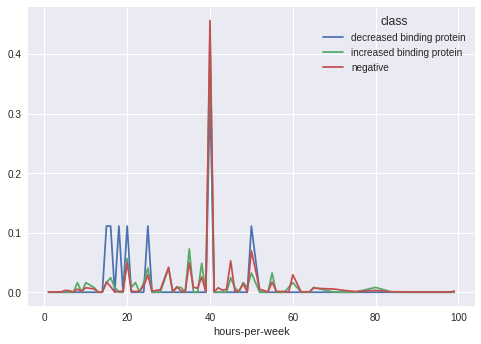

In [36]:
pd.crosstab(index=train_t["class"],  columns=[train_t["hours-per-week"]], normalize = "index").transpose().plot()

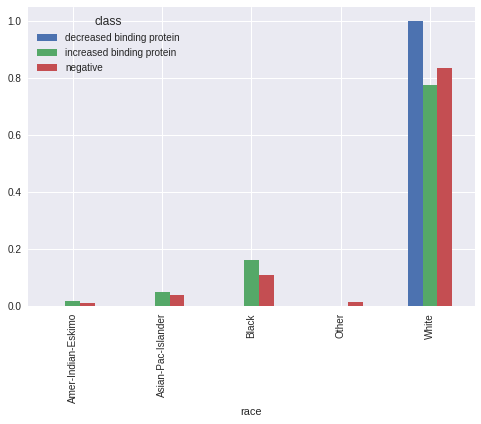

In [37]:
pd.crosstab(index=train_t["race"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')



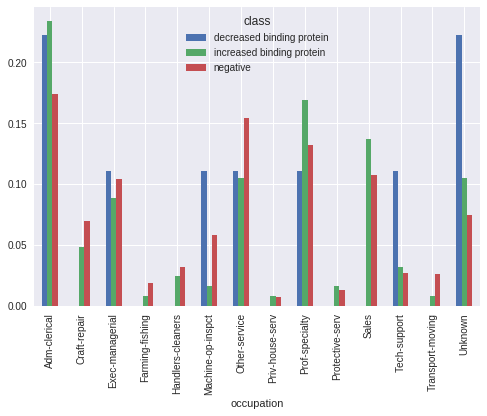

In [38]:
pd.crosstab(index=train_t["occupation"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


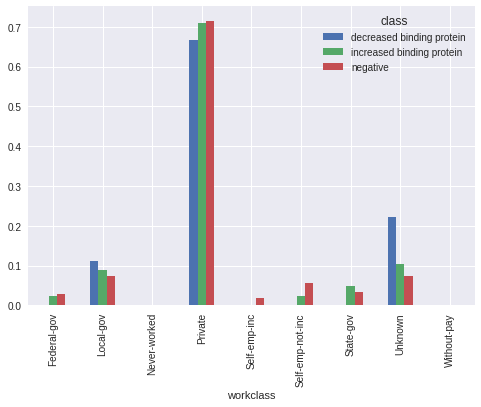

In [39]:
pd.crosstab(index=train_t["workclass"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


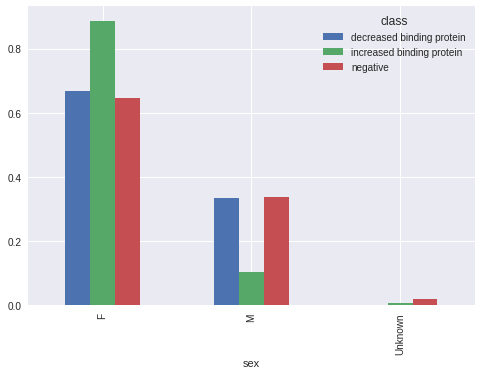

In [40]:
pd.crosstab(index=train_t["sex"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


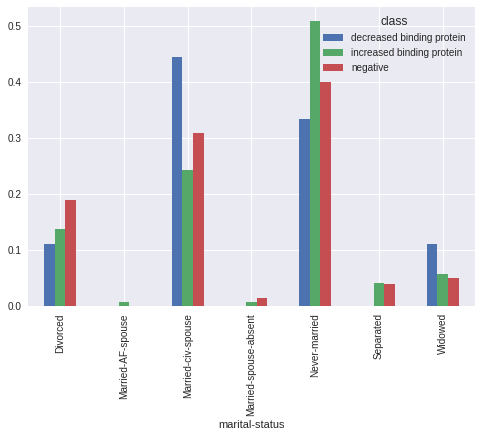

In [41]:
pd.crosstab(index=train_t["marital-status"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


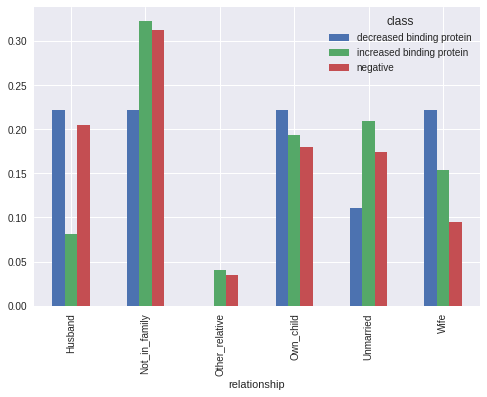

In [42]:
pd.crosstab(index=train_t["relationship"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


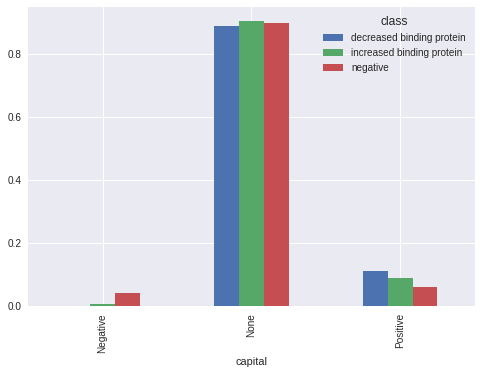

In [43]:
pd.crosstab(index=train_t["capital"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

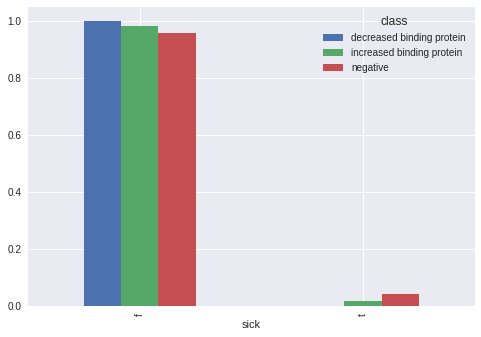

In [44]:
pd.crosstab(index=train_t["sick"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


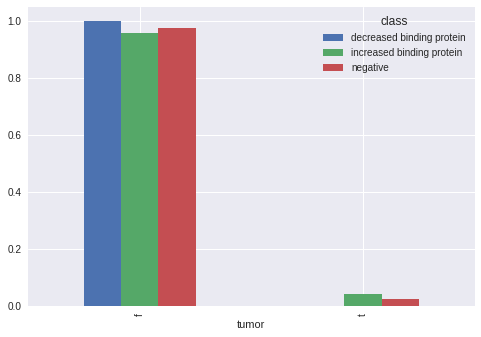

In [45]:
pd.crosstab(index=train_t["tumor"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


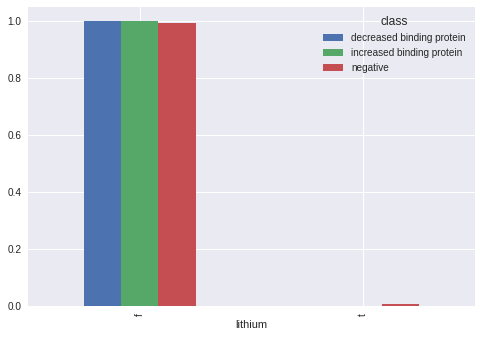

In [46]:
pd.crosstab(index=train_t["lithium"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')


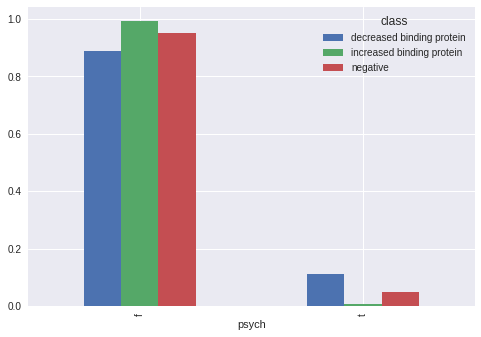

In [47]:
pd.crosstab(index=train_t["psych"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

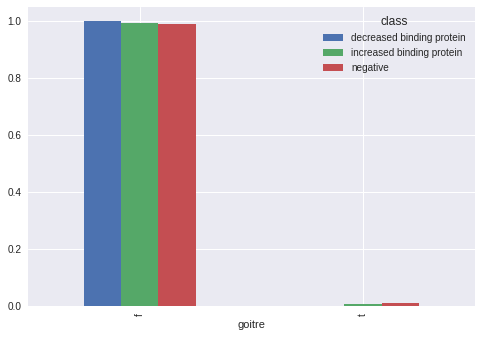

In [48]:
pd.crosstab(index=train_t["goitre"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

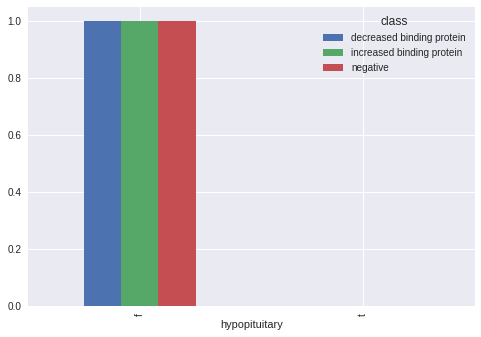

In [49]:
pd.crosstab(index=train_t["hypopituitary"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

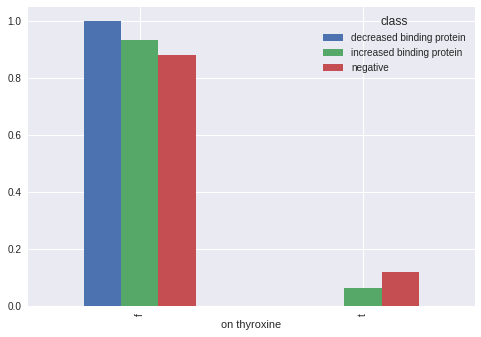

In [50]:
pd.crosstab(index=train_t["on thyroxine"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

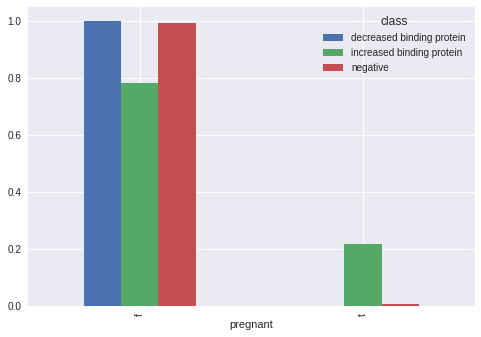

In [51]:
pd.crosstab(index=train_t["pregnant"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

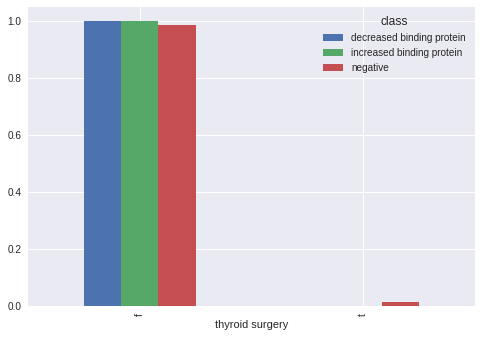

In [52]:
pd.crosstab(index=train_t["thyroid surgery"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

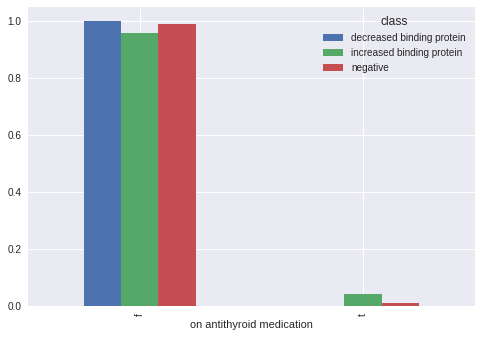

In [53]:
pd.crosstab(index=train_t["on antithyroid medication"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

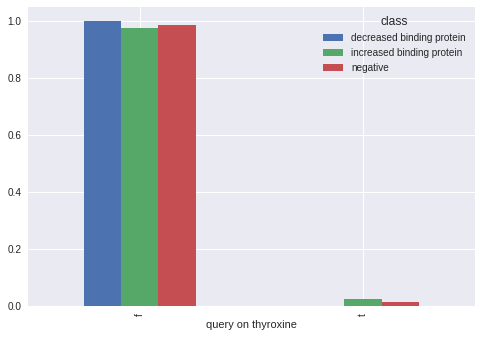

In [54]:
pd.crosstab(index=train_t["query on thyroxine"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

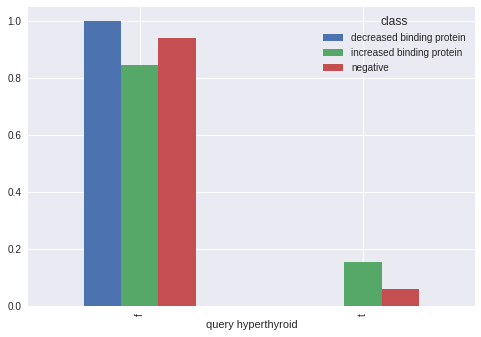

In [55]:
pd.crosstab(index=train_t["query hyperthyroid"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

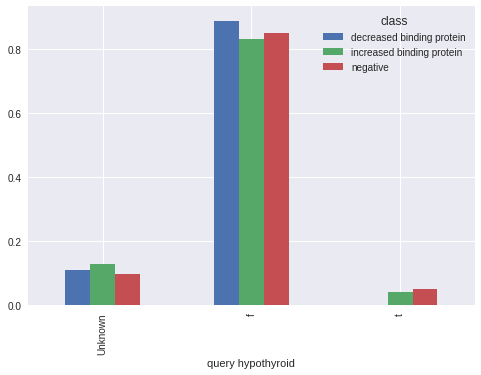

In [56]:
pd.crosstab(index=train_t["query hypothyroid"], columns=[train_t["class"]], normalize = 'columns').plot(kind='bar')

#Bool columns

,Unknown,f,t
query on thyroxine,NaN,2759.0,40.0
on antithyroid medication,NaN,2765.0,34.0
thyroid surgery,NaN,2760.0,39.0
I131 treatment,NaN,2752.0,47.0
tumor,NaN,2728.0,71.0
hypopituitary,NaN,2798.0,1.0
goitre,NaN,2774.0,25.0
lithium,NaN,2785.0,14.0
on thyroxine,NaN,2470.0,329.0
pregnant,NaN,2758.0,41.0


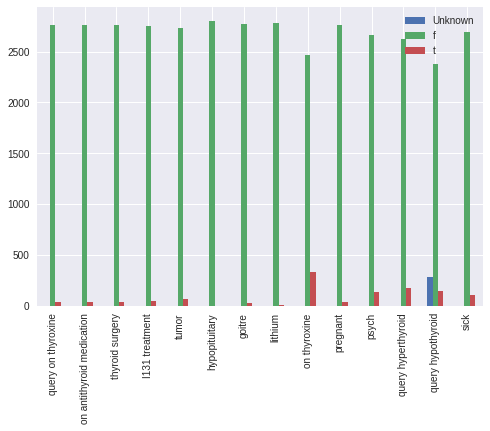

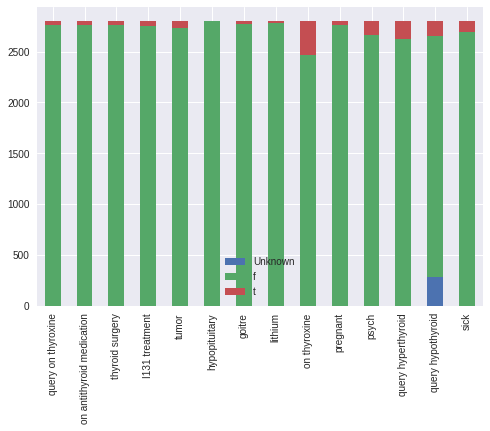

In [57]:
bool_columns_list = ['query on thyroxine', 'on antithyroid medication', 'thyroid surgery', 'I131 treatment', 'tumor', 'hypopituitary', 'goitre', 'lithium', 'on thyroxine', 'pregnant', 'psych', 'query hyperthyroid', 'query hypothyroid', 'sick']

value_counts = train_t[bool_columns_list].apply(pd.Series.value_counts).transpose()
value_counts.plot(kind="bar")
value_counts.plot.bar(stacked=True)
value_counts

# Saving preprocessed data

In [0]:
train_t.to_csv('preprocesed_train_data.csv', sep=',');
test_t.to_csv('preprocesed_test_data.csv', sep=',');

# Zhrnutie

V tomto zadani sme vramci predspracovania:
* vyplnili chybajuce hodnoty vsetkych atributov
  - na doplnenie chybajucich hodnot T4U, T3 a FTI boli doplnene pomocou linearnej regresie podla atributu TT4
  - zvysne chybajuce hodnoty atributov TSH, T3, TT4, T4U, FTI a age boli doplnene ich priemernou hodnotou
  - niektore chybajuce hodnoty atributu sex boli doplnene na zaklade atributu relationship, ktore o danom zazname mohli špecifikovať pohlavie hodnotami Husband alebo Wife
  - zvysne kategoricke atributy sme doplnili jednotnou hodnotou "Unknown"
* nahradili outlierov pomocou quantilov 0.05 a 0.95 (konkretne pri atributoch TSH, TT4, T3, FTI, age)
* vykonali normalizaciu hodnot atributov TT4, FTI, T3, TSH, T4U
* zjednotili nekonzistentne hodnoty
  - boolovskych atributov na "t" a "f"
  - odstranili prazdny znak medzery, ktory sa vyskytoval na zaciatku hodnot niektorych atributov (napr: " Husband")
  - zjednotili formaty datumov narodenia do formatu (YYYY-MM-DD)
* zlucili niektore atributy do jedneho (napriklad capital-gain a capital-loss do jedneho atributu)
* odstranili niektore atributy, ktore bud duplikovali iny atribut, ktory hovoril o tom istom (education a education-num), alebo neposkytovali ziadne informacie (TBG,TBG measured...)

Predspracovane trenovacie a testovacie data sme ulozili do prislusnych suborov formatu csv

Okrem toho sme na predspracovaných dátach opätovne spravili prieskumnú analýzu vo forme grafov a výpisov početností hodnôt pre jednotlivé atribúty, v ktorých sa priamo odzrkadľujú úpravy aplikované nad dátami



**1. Ako sme zmenili distribucie hodnot po realizacii krokov predspracovania?**

Atributy TSH, T3, TT4, T4U, FTI boli znormalizovane a ohranicene outliermi. Niektorym dvojiciam tychto markrov sa zvysil korelacny koeficient, z dovodu doplnania chybajucich hodnot pomocou linearnej regresie.
Niektorym vyssie uvedenym kategorickym atributom boli priradene hodnoty ktore predtym chybali, cize sa im mohla jemne zmenit distribucia.


**2. Su niektore atributy medzi sebou zavisle?**

* Markre medzi sebou
* age, date_of_birth
* sex, relationship

**3. Od ktorych atributov zavisi predikovana premenna?**

Najviac relevantné atribúty, od ktorých je zavisla class sú T3, TT4, T4U na základe grafov závislosti.
Menej relevantne ale su aj kategoricke premenne 'goitree', 'query hyper/hypo thyroid' a 'tumor'

Klasifikator:

Ďalej v ramci klasifikacie sme si vytvorili vlastny klasifikacny model, ktory pozostaval z nami navrhnutych pravidiel. Pravidla pozostavali hlavne z markrov ale vystupoval v nich aj atribut age, ktory vysledky o nieco zlepsil. Spôsob vytvárania pravidiel bol pomocou lineárneho ohraničovania.
Vysledky klasifikacie sú nasledovne: __Accuracy: 0.976337, Precision: 0.784755, Recall: 0.703482__


